<a href="https://colab.research.google.com/github/YS-JEOUNG/amazon-review-project/blob/main/code/final_2_lstm_gru_1dcnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 토큰화

## Import

In [ ]:
# 기본
import pandas as pd
import numpy as np

# Warnings   
import warnings
from scipy import stats
warnings.filterwarnings('ignore')

import re
import urllib.request       # 왜 넣는걸까

# 시각화
%matplotlib inline
import matplotlib.pyplot as plt

# nltk
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk import word_tokenize, sent_tokenize, regexp_tokenize
from nltk.corpus import stopwords
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem import WordNetLemmatizer, PorterStemmer

import string, unicodedata
from bs4 import BeautifulSoup

!pip install contractions
from contractions import contractions_dict

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
     |████████████████████████████████| 286kB 10.6MB/s 
     |████████████████████████████████| 327kB 43.2MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85394 sha256=b3578543d05edad3b2d0c1380001e28a63a152f1a4b29945de37eabedcc1294b
  Stored in directory: /root/.cache/pip/wheels/3a/03/34/77e3ece0bba8b86bfac88a79f923b36d805cad63caeba38842
Successfully built pyahocorasick


In [ ]:
# 훈련 및 모델 생성
import sklearn
import keras
from sklearn.model_selection import train_test_split

# LSTM
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# GRU
from tensorflow.keras.layers import GRU

# 1D CNN
from tensorflow.keras.layers import Conv1D, Dropout, GlobalMaxPool1D

In [ ]:
# confusion matrix
from sklearn.metrics import confusion_matrix     
import seaborn as sns

## Data

In [ ]:
# 파일 불러오기
total = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/project/final_data_clean.csv')

FileNotFoundError: ignored

## 토큰화

In [ ]:
# good/bad 개수 확인
total['rating_class'].value_counts()

good    2407786
bad      315538
Name: rating_class, dtype: int64

In [ ]:
# good/bad 비율 맞추기 위해 bad 개수에 맞춰서 good 자르기
total = total.sort_values(by='rating_class')
total.head()

,ratings,vote,verified,reviewer_id,prod_id,reviewer_name,unix_review_time,prod_name,price,review_text,rating_class,time,clean_text
2723323,1.0,3,True,A172Y8313QKCNZ,B01HJHR2PM,spartacus,1474416000,Mural Art 12 Colors Waterproof Metal Glass Fin...,$10.99,One color I received these earlier than expect...,bad,2016-09-21,one color receive earlier expect request refun...
425653,1.0,0,True,A1URY8FPOSN4XF,B001UAUI88,Trish Wilson,1476576000,Stakich Pure White BEESWAX Pellets - 100% Nat...,$81.95,Not As Advertized. The package did not weigh ...,bad,2016-10-16,not advertize package not weigh ounces adverti...
2344252,1.0,3,True,A1E3GZTNFSM5D2,B00L6JSXSU,Paul,1510272000,Bernat Blanket Big Ball Yarn (10044) Dark Grey,$21.12,... in the store so i found this and was happy...,bad,2017-11-10,store find happy find skinnier blanket get yar...
1735919,2.0,0,True,A1HPP2D0V5TN4Q,B000A56PUO,Jen,1340150400,"THE PAPER COMPANY, P62526, White Cardstock Val...",$14.94,thin This is not as thick as cardstock I am us...,bad,2012-06-20,thin not thick cardstock use not actually use ...
2344261,1.0,0,False,A3HTN8YLEEZRJ5,B00L6FKI8C,C. Zellmer,1442016000,Corset Tie Lace-up Replacement Pale Ivory Sati...,$24.95,I am pretty disappointed. I ordered directly f...,bad,2015-09-12,pretty disappoint order directly website prett...


In [ ]:
total = total[:700_000]
total['rating_class'].value_counts()

good    384462
bad     315538
Name: rating_class, dtype: int64

In [ ]:
total.isnull().sum()

ratings                  0
vote                     0
verified                 0
reviewer_id              0
prod_id                  0
reviewer_name           23
unix_review_time         0
prod_name                0
price               147506
review_text              0
rating_class             0
time                     0
clean_text              38
dtype: int64

In [ ]:
# 귀찮으니 필요정보인 rating_class와 clean_text만 남기고 드랍하자.
total = total[['clean_text', 'rating_class']]
total.head(3)

,clean_text,rating_class
2723323,one color receive earlier expect request refun...,bad
425653,not advertize package not weigh ounces adverti...,bad
2344252,store find happy find skinnier blanket get yar...,bad


In [ ]:
# rating_class를 숫자화하자. good 1, bad 0
total['rating_class'] = total['rating_class'].apply(lambda x: 0 if x == 'bad' else 1)

In [ ]:
# clean_text에 null값이 있으니 드랍하자.
total = total.dropna(subset=['clean_text'])

In [ ]:
total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 699962 entries, 2723323 to 1764020
Data columns (total 2 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   clean_text    699962 non-null  object
 1   rating_class  699962 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 16.0+ MB


In [ ]:
total.head()

,clean_text,rating_class
2723323,one color receive earlier expect request refun...,0
425653,not advertize package not weigh ounces adverti...,0
2344252,store find happy find skinnier blanket get yar...,0
1735919,thin not thick cardstock use not actually use ...,0
2344261,pretty disappoint order directly website prett...,0


In [ ]:
# bad / good 순서로 되어 있으므로 랜덤으로 섞자.
total = sklearn.utils.shuffle(total)
total.head()

,clean_text,rating_class
1988609,awful hoop hoop much cheaper name brand hoop w...,0
2459426,bad design not fan keep fall apart lock systeh...,0
1896429,five star soft,1
911607,not satisfy product one write one use company ...,0
1954217,small not worth price inaccurate dimension lis...,1


In [ ]:
X = total['clean_text']
y = total['rating_class']

In [ ]:
tokenizer = Tokenizer(split=' ')
tokenizer.fit_on_texts(X)

In [ ]:
sequences = tokenizer.texts_to_sequences(X)
word_index = tokenizer.word_index

In [ ]:
len(word_index)

132670

In [ ]:
sequences[0]

[509,
 730,
 730,
 41,
 595,
 462,
 131,
 730,
 5,
 102,
 21,
 61,
 372,
 730,
 730,
 3,
 717,
 117,
 5,
 227,
 68,
 111,
 61,
 435,
 502]

In [ ]:
# 등장 빈도수가 15 미만인 단어들이 차지하는 비중
threshold = 15
total_cnt = len(word_index)
rare_cnt = 0      # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0    # 훈련 데이터의 전체 단어 빈도수 총합
rare_freq = 0     # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총합

# 단어와 빈도수 > key, value
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어 등장 빈도수가 threshold보다 작으면
    if value < threshold:
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합의 크기:', total_cnt)
print(f'등장 빈도가 {threshold}번 미만인 희귀 단어의 수:', rare_cnt)
print('단어 집합에서 희귀 단어의 비율:', (rare_cnt / total_cnt) * 100)
print('전체 등장 빈도에서 희귀 단어 등장 빈도 비율:', (rare_freq / total_freq) * 100)

단어 집합의 크기: 132670
등장 빈도가 15번 미만인 희귀 단어의 수: 119516
단어 집합에서 희귀 단어의 비율: 90.08517373935328
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.7197218589865317


In [ ]:
# 등장 빈도수가 15 미만인 단어는 제거
# 0번 패딩 토큰을 고려하여 +1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기:', vocab_size)

단어 집합의 크기: 13155


In [ ]:
tokenizer = Tokenizer(vocab_size)
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)

In [ ]:
# 빈도수가 낮은 단어들이 삭제되었으므로 빈 샘플들이 존재할 것. 빈 샘플 제거.
# >>>>>>> 문제: 그러면 너무 많은 리뷰가 삭제될 것 같은데?
drop_train = [index for index, sentence in enumerate(X) if len(sentence) < 1]
drop_train
# >>>>>>> 해결: 아니다. 고작 32개밖에 안 된다. 밑에서 X, y에서 삭제할 때 에러만 계속 뜨므로 굳이 삭제하지 않아도 될 것 같다.

[17980,
 48292,
 52033,
 78494,
 82467,
 140923,
 144312,
 165878,
 189433,
 201996,
 218567,
 227294,
 259097,
 263964,
 297700,
 324652,
 327484,
 348980,
 379384,
 385436,
 393981,
 400096,
 415852,
 416208,
 432049,
 438269,
 448679,
 455195,
 482533,
 520307,
 535911,
 673842]

In [ ]:
total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 699962 entries, 1988609 to 1680812
Data columns (total 2 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   clean_text    699962 non-null  object
 1   rating_class  699962 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 16.0+ MB


## 패딩

리뷰의 최대 길이: 1339
리뷰의 평균 길이: 19.380012057797423


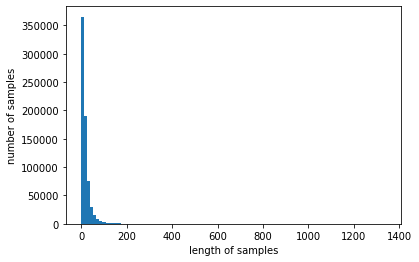

In [ ]:
# 가장 길이가 긴 리뷰와 전체 데이터의 길이 분포 확인
print('리뷰의 최대 길이:', max(len(l) for l in X))
print('리뷰의 평균 길이:', sum(map(len, X)) / len(X))
plt.hist([len(s) for s in X], bins=100)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
# 전체 샘플 중 길이가 max_len 이하인 샘플의 비율이 몇%인지 확인
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if len(s) <= max_len:
            cnt = cnt + 1
    print(f'전체 샘플 중 길이가 {max_len} 이하인 샘플의 비율:', (cnt/len(nested_list))*100, '%')

In [ ]:
max_len = 100
below_threshold_len(max_len, X)

전체 샘플 중 길이가 100 이하인 샘플의 비율: 98.68850023286979 %


In [ ]:
# 그러면 모든 샘플의 길이를 100으로 맞추자.
X = pad_sequences(X, maxlen=max_len)

# 훈련

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)
X_train.shape, X_test.shape

((524971, 100), (174991, 100))

In [ ]:
y_train.shape, y_test.shape

((524971,), (174991,))

# LSTM

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(LSTM(units=128, return_sequences=True))
model.add(Dense(units=1, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         1315500   
_________________________________________________________________
lstm (LSTM)                  (None, None, 128)         117248    
_________________________________________________________________
dense_1 (Dense)              (None, None, 1)           129       
Total params: 1,432,877
Trainable params: 1,432,877
Non-trainable params: 0
_________________________________________________________________


In [ ]:
es = EarlyStopping(monitor='val_loss', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics='acc')
history = model.fit(X_train, y_train, epochs=100, callbacks=[es, mc], batch_size=512, validation_split=0.2)

Epoch 1/100
821/821 [==============================] - 77s 82ms/step - loss: 0.6360 - acc: 0.6082 - val_loss: 0.6110 - val_acc: 0.6243

Epoch 00001: val_acc improved from -inf to 0.62430, saving model to best_model.h5
Epoch 2/100
821/821 [==============================] - 67s 82ms/step - loss: 0.6069 - acc: 0.6258 - val_loss: 0.6090 - val_acc: 0.6251

Epoch 00002: val_acc improved from 0.62430 to 0.62507, saving model to best_model.h5
Epoch 3/100
821/821 [==============================] - 66s 81ms/step - loss: 0.6014 - acc: 0.6293 - val_loss: 0.6085 - val_acc: 0.6253

Epoch 00003: val_acc improved from 0.62507 to 0.62533, saving model to best_model.h5
Epoch 4/100
821/821 [==============================] - 65s 80ms/step - loss: 0.5984 - acc: 0.6290 - val_loss: 0.6074 - val_acc: 0.6254

Epoch 00004: val_acc improved from 0.62533 to 0.62543, saving model to best_model.h5
Epoch 5/100
821/821 [==============================] - 65s 80ms/step - loss: 0.5950 - acc: 0.6312 - val_loss: 0.6101 - 

In [ ]:
hist = pd.DataFrame(history.history)

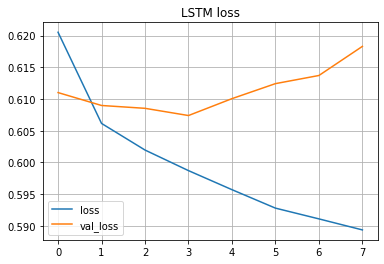

In [ ]:
hist[['loss', 'val_loss']].plot()
plt.title('LSTM loss')
plt.grid()
plt.show()

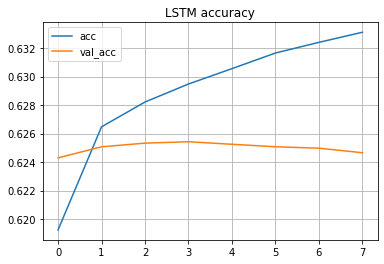

In [ ]:
hist[['acc', 'val_acc']].plot()
plt.title('LSTM accuracy')
plt.grid()
plt.show()

In [ ]:
import keras

In [ ]:
best_model = keras.models.load_model('best_model.h5')
test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=1)
pred = best_model.predict(X_test)
print('model accuracy:', test_acc)

5469/5469 [==============================] - 61s 11ms/step - loss: 0.6066 - acc: 0.6259
model accuracy: 0.6258820295333862


## confusion matrix

In [ ]:
# series를 1차원 array로 바꾸고 정수로 맞춰주기
a = y_test.to_numpy(int)
a

array([1, 1, 0, ..., 1, 1, 0])

In [ ]:
a.shape

(174991,)

In [ ]:
# 2차원 array를 1차원 array로 바꾸고 정수로 맞춰주기
# GRU 할 때는 이것까지만 하고도 아무 문제 없이 confusion matrix를 만들 수 있었으나
# LSTM은 b가 (174991, 100, 1)이라 reshape하면 (17499100, 1)이 되어버림
# 왜 그런건지는 모르겠으나 일단 b를 (174991, 1)로 만들어주겠다
b = np.around(pred, 0).astype(int).reshape(-1,)
b

array([1, 1, 1, ..., 0, 0, 0])

In [ ]:
# 이렇게 되어버린다는 뜻이다
np.around(pred, 0).astype(int).shape

(174991, 100, 1)

In [ ]:
# [[[1 or 0]이 100개 들어있는 리스트]가 100개 들어 있는 리스트]이므로
# 제일 안쪽 원소 1개짜리 리스트 100개를 하나의 리스트에 집어넣어 버리고
# 리스트 안의 숫자를 다 합하고 100으로 나누면 0 이상 1 이하의 1차원 배열이 됨
# 리스트와 배열을 혼용해서 말하고 있지만 대충 그렇다고 하자 아마 배열이 맞는 말이겠지...?
b = np.around(pred, 0).astype(int).reshape(-1, 100).sum(axis=1)
b = b/100
b

array([0.99, 1.  , 0.41, ..., 1.  , 1.  , 0.73])

In [ ]:
# a랑 맞추기 위해 숫자가 1인 건 1로 놔두고 소수점이 있거나 0인 건 다 0으로 버리자
# 그러면 0, 1이 대충 a에서랑 비슷하게 나와서 그렇게 해보긴 했는데
# 왜 그러는 건지는 잘 모르겠다
b = np.floor(b).astype(int)
b

array([0, 1, 0, ..., 1, 1, 0])

In [ ]:
# confusion matrix 만들기
conf_matrix = pd.DataFrame(confusion_matrix(a, b), index = ['bad', 'good'], columns=['bad', 'good'])

# normalize
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

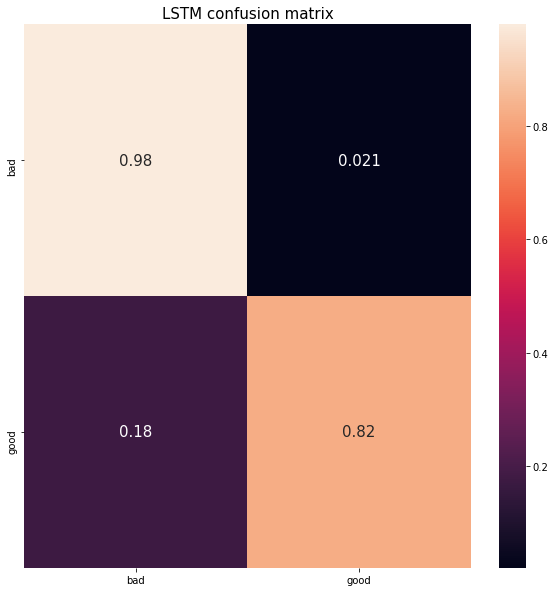

In [ ]:
# 조금 당황스럽다 위에서 정확도 이렇게 안나왔으면서 왜 cf_mt에서는 정확도가 더 좋지?
# a, b 처리할 때 뭐가 바뀐건가?
# 시각화
plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, annot=True, annot_kws={'size':15})     # annot=True: 각 셀에 숫자 입력
plt.title('LSTM confusion matrix', fontsize=15)
plt.show()

In [ ]:
# 1과 0이 되게 소수점을 버려버린 게 문제인가 싶어서 반올림을 사용해봤다
b = np.around(pred, 0).astype(int).reshape(-1, 100).sum(axis=1)
b = b/100
b

array([0.99, 1.  , 0.41, ..., 1.  , 1.  , 0.73])

In [ ]:
b = np.round(b).astype(int)
b

array([1, 1, 0, ..., 1, 1, 1])

In [ ]:
# confusion matrix 만들기
conf_matrix = pd.DataFrame(confusion_matrix(a, b), index = ['bad', 'good'], columns=['bad', 'good'])

# normalize
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

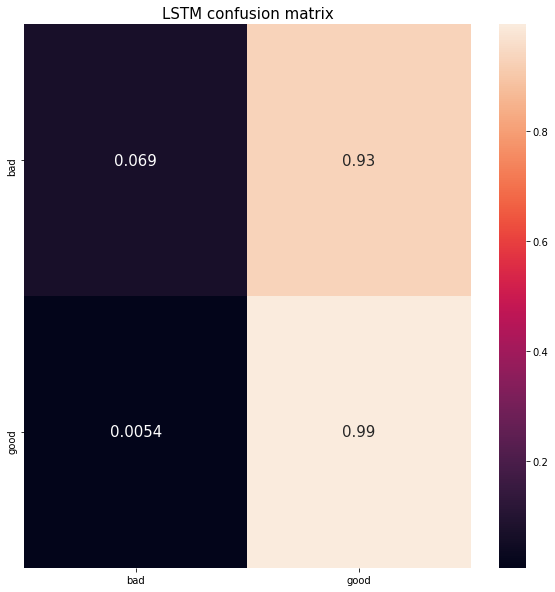

In [ ]:
# 이 결과는 뭘까 이해할 수 없다 아마 b가 다 1이 되어버린 것 같다
# 이건 틀린 것 같다
# 시각화
plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, annot=True, annot_kws={'size':15})     # annot=True: 각 셀에 숫자 입력
plt.title('LSTM confusion matrix', fontsize=15)
plt.show()

In [ ]:
# 총평:
# GRU는 멀쩡하게 잘만 돌아가는데 LSTM은 왜 차원도 이상하게 나오고 결과도 이상하게 나올까 뭔가 잘못한 게 있는걸까 뭐가 잘못된 걸까

# GRU

## 60

In [ ]:
model2 = Sequential()
model2.add(Embedding(vocab_size, 100))
model2.add(GRU(128))
model2.add(Dense(1, activation='sigmoid'))

In [ ]:
es = EarlyStopping(monitor='val_loss', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [ ]:
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics='acc')
history2 = model2.fit(X_train, y_train, epochs=100, callbacks=[es, mc], batch_size=60, validation_split=0.2)

Epoch 1/100
7000/7000 [==============================] - 320s 41ms/step - loss: 0.1922 - acc: 0.9208 - val_loss: 0.1388 - val_acc: 0.9473

Epoch 00001: val_acc improved from -inf to 0.94726, saving model to best_model.h5
Epoch 2/100
7000/7000 [==============================] - 291s 42ms/step - loss: 0.1257 - acc: 0.9519 - val_loss: 0.1354 - val_acc: 0.9483

Epoch 00002: val_acc improved from 0.94726 to 0.94831, saving model to best_model.h5
Epoch 3/100
7000/7000 [==============================] - 288s 41ms/step - loss: 0.1060 - acc: 0.9606 - val_loss: 0.1373 - val_acc: 0.9479

Epoch 00003: val_acc did not improve from 0.94831
Epoch 4/100
7000/7000 [==============================] - 285s 41ms/step - loss: 0.0891 - acc: 0.9666 - val_loss: 0.1515 - val_acc: 0.9447

Epoch 00004: val_acc did not improve from 0.94831
Epoch 5/100
7000/7000 [==============================] - 286s 41ms/step - loss: 0.0728 - acc: 0.9733 - val_loss: 0.1645 - val_acc: 0.9449

Epoch 00005: val_acc did not improve f

In [ ]:
hist2 = pd.DataFrame(history2.history)

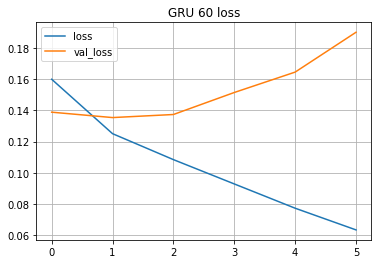

In [ ]:
hist2[['loss', 'val_loss']].plot()
plt.title('GRU 60 loss')
plt.grid()
plt.show()

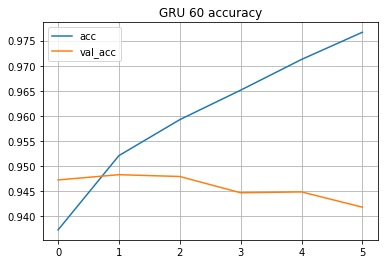

In [ ]:
hist2[['acc', 'val_acc']].plot()
plt.title('GRU 60 accuracy')
plt.grid()
plt.show()

In [ ]:
best_model = keras.models.load_model('best_model.h5')
test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=1)
pred = best_model.predict(X_test)
print('model accuracy:', test_acc)

5469/5469 [==============================] - 57s 10ms/step - loss: 0.1359 - acc: 0.9474
model accuracy: 0.9473801255226135


### confusion matrix

In [ ]:
# series를 1차원 array로 바꾸고 정수로 맞춰주기
a = y_test.to_numpy(int)
a

array([1, 1, 1, ..., 1, 0, 1])

In [ ]:
# 2차원 array를 1차원 array로 바꾸고 정수로 맞춰주기
b = np.around(pred, 0).astype(int).reshape(-1,)
b

array([1, 1, 1, ..., 1, 0, 1])

In [ ]:
# confusion matrix 만들기
conf_matrix = pd.DataFrame(confusion_matrix(a, b), index = ['bad', 'good'], columns=['bad', 'good'])

# normalize
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

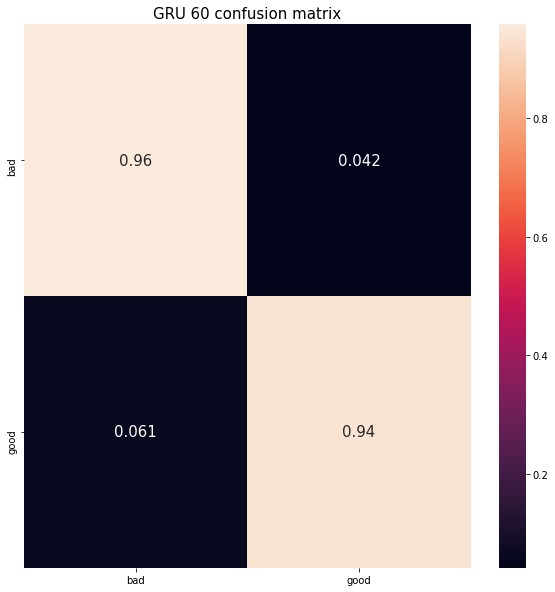

In [ ]:
# 시각화
plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, annot=True, annot_kws={'size':15})     # annot=True: 각 셀에 숫자 입력
plt.title('GRU 60 confusion matrix', fontsize=15)
plt.show()

### 실제 샘플 예측

#### 토큰화, 불용어 제거 등을 위한 import와 함수 정의(앞의 것과 동일)

In [ ]:
import re
import urllib.request       # 왜 넣는걸까

# 시각화
%matplotlib inline
import matplotlib.pyplot as plt

# nltk
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk import word_tokenize, sent_tokenize, regexp_tokenize
from nltk.corpus import stopwords
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem import WordNetLemmatizer, PorterStemmer

import string, unicodedata
from bs4 import BeautifulSoup

!pip install contractions
from contractions import contractions_dict

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
def strip_html(text):
  # html코드 제거 함수
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def remove_between_square_brackets(text):
  # 괄호로 묶여있는 단어 제거
    return re.sub('\[[^]]*\]', '', text)

def denoise_text(text):
  # 위에 함수 두개 과정 진행하는 함수
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text


# Define function to expand contractions
def expand_contractions(text):
  # IGNORECASE =  대소문자 관련 없이, DOTALL = 줄바꿈기호 상관없이 매칭해달라는 의미
  # re를 이용하여 정규표현식으로 매칭을 할 때 contractions_dict의 키를   
  # 찾고자 하는 형태를 만든뒤 매칭하여 축약문들을 확장 시키는 과정인듯
    contractions_pattern = re.compile('({})'.format('|'.join(contractions_dict.keys())),flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contractions_dict.get(match)\
                        if contractions_dict.get(match)\
                        else contractions_dict.get(match.lower())
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
    
    try:
      expanded_text = contractions_pattern.sub(expand_match, text)
      expanded_text = re.sub("'", "", expanded_text)
    except:
      return text
    return expanded_text


# special_characters removal
def remove_special_characters(text, remove_digits=True):
  # 문자, 숫자가 아닌것들을 제거
  # r은 정규 표현식을 쓸 때 가독성을 위한 장치 raw string이라는 의미
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text


def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words


def remove_punctuation_and_splchars(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_word = remove_special_characters(new_word, True)
            new_words.append(new_word)
    return new_words

def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

stopword_list= stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')
#stopword_list.remove('headphone')
#stopword_list.remove('headphones')
#stopword_list.remove('earbuds')
#stopword_list.remove('bud')
#stopword_list.remove('ear')
#stopword_list.remove('sony')
#stopword_list.remove('product')


def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopword_list:
            new_words.append(word)
    return new_words

# 어간 추출
def stem_words(words):      
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

# 표제어 추출
def lemmatize_verbs(words): 
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

In [ ]:
def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation_and_splchars(words)
    words = remove_stopwords(words)
    return words

def lemmatize(words):
    lemmas = lemmatize_verbs(words)
    return lemmas

In [ ]:
def normalize_and_lemmatize(input):
    sample = denoise_text(input)
    sample = expand_contractions(sample)
    sample = remove_special_characters(sample)
    words = nltk.word_tokenize(sample)
    words = normalize(words)
    lemmas = lemmatize(words)
    return ' '.join(lemmas)

#### 샘플 예측

In [ ]:
def sentiment_predict(new_sentence):
    encoded = tokenizer.texts_to_sequences([new_sentence])    # 정수 인코딩
    pad_new = pad_sequences(encoded, maxlen = max_len)     # 패딩
    score = float(best_model.predict(pad_new))   # 예측
    if score > 0.5:
        print(f'{score*100}% 확률로 긍정 리뷰입니다.')
    else:
        print(f'{(1-score)*100}% 확률로 부정 리뷰입니다.')

In [ ]:
sentiment_predict("I purchased my first laminator and had no idea what thermal pouches to purchase. I was not sure what brand would be best and what thickness would be most effective, the 3mil or 5mil. After much thought I finally decided to give these a try and I'm really glad I did! I don't have anything to compare them to as this was my first time using these; however, they worked great and I didn't have any issues. These are the 3mil. When I run out I will be purchasing more!")

50.45440196990967% 확률로 긍정 리뷰입니다.


In [ ]:
sentiment_predict("Waste of time and money. I had been using Scotch brand which worked beautifully. Then I switched to these. Not one thing laminated was right. What I laminated was ruined, it was to late to be able to return the pouches because I ordered them at the same time as the Scotch ones which I used first. So waste of money and huge waste of my time trying to laminate things and then fix them.")

99.57830305211246% 확률로 부정 리뷰입니다.


In [ ]:
# 맞췄다!!!

In [ ]:
# 총평:
# 만족

## 256

In [ ]:
model3 = Sequential()
model3.add(Embedding(vocab_size, 100))
model3.add(GRU(128))
model3.add(Dense(1, activation='sigmoid'))

In [ ]:
es = EarlyStopping(monitor='val_loss', verbose=1, patience=4)
mc = ModelCheckpoint('best_model3.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [ ]:
model3.compile(optimizer='adam', loss='binary_crossentropy', metrics='acc')
history3 = model3.fit(X_train, y_train, epochs=100, callbacks=[es, mc], batch_size=256, validation_split=0.2)

Epoch 1/100
1641/1641 [==============================] - 108s 64ms/step - loss: 0.2261 - acc: 0.9006 - val_loss: 0.1500 - val_acc: 0.9417

Epoch 00001: val_acc improved from -inf to 0.94167, saving model to best_model3.h5
Epoch 2/100
1641/1641 [==============================] - 101s 61ms/step - loss: 0.1335 - acc: 0.9491 - val_loss: 0.1391 - val_acc: 0.9460

Epoch 00002: val_acc improved from 0.94167 to 0.94599, saving model to best_model3.h5
Epoch 3/100
1641/1641 [==============================] - 101s 62ms/step - loss: 0.1138 - acc: 0.9570 - val_loss: 0.1445 - val_acc: 0.9461

Epoch 00003: val_acc improved from 0.94599 to 0.94614, saving model to best_model3.h5
Epoch 4/100
1641/1641 [==============================] - 104s 64ms/step - loss: 0.1002 - acc: 0.9628 - val_loss: 0.1468 - val_acc: 0.9441

Epoch 00004: val_acc did not improve from 0.94614
Epoch 5/100
1641/1641 [==============================] - 101s 62ms/step - loss: 0.0876 - acc: 0.9680 - val_loss: 0.1554 - val_acc: 0.9434



In [ ]:
hist3 = pd.DataFrame(history3.history)

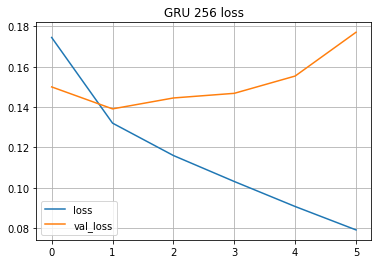

In [ ]:
hist3[['loss', 'val_loss']].plot()
plt.title('GRU 256 loss')
plt.grid()
plt.show()

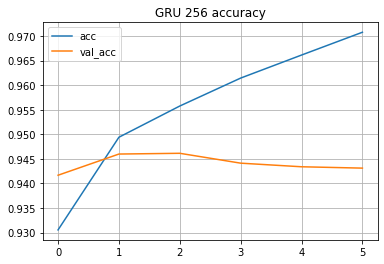

In [ ]:
hist3[['acc', 'val_acc']].plot()
plt.title('GRU 256 accuracy')
plt.grid()
plt.show()

In [ ]:
best_model3 = keras.models.load_model('best_model3.h5')
test_loss, test_acc = best_model3.evaluate(X_test, y_test, verbose=1)
pred = best_model3.predict(X_test)
print('model accuracy:', test_acc)

5469/5469 [==============================] - 56s 10ms/step - loss: 0.1459 - acc: 0.9454
model accuracy: 0.9454257488250732


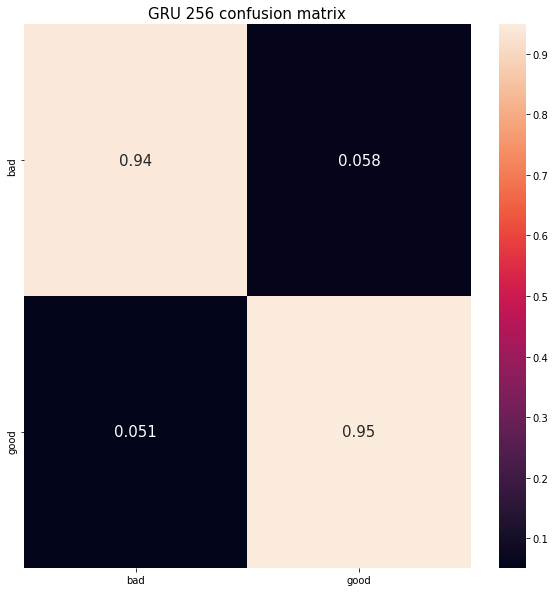

In [ ]:
a = y_test.to_numpy(int)
b = np.around(pred, 0).astype(int).reshape(-1,)
conf_matrix = pd.DataFrame(confusion_matrix(a, b), index = ['bad', 'good'], columns=['bad', 'good'])
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, annot=True, annot_kws={'size':15})     # annot=True: 각 셀에 숫자 입력
plt.title('GRU 256 confusion matrix', fontsize=15)
plt.show()

## 512

In [ ]:
model4 = Sequential()
model4.add(Embedding(vocab_size, 100))
model4.add(GRU(128))
model4.add(Dense(1, activation='sigmoid'))

In [ ]:
es = EarlyStopping(monitor='val_loss', verbose=1, patience=4)
mc = ModelCheckpoint('best_model4.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [ ]:
model4.compile(optimizer='adam', loss='binary_crossentropy', metrics='acc')
history4 = model4.fit(X_train, y_train, epochs=100, callbacks=[es, mc], batch_size=512, validation_split=0.2)

Epoch 1/100
821/821 [==============================] - 65s 77ms/step - loss: 0.2605 - acc: 0.8786 - val_loss: 0.1521 - val_acc: 0.9411

Epoch 00001: val_acc improved from -inf to 0.94115, saving model to best_model4.h5
Epoch 2/100
821/821 [==============================] - 62s 75ms/step - loss: 0.1399 - acc: 0.9469 - val_loss: 0.1475 - val_acc: 0.9434

Epoch 00002: val_acc improved from 0.94115 to 0.94343, saving model to best_model4.h5
Epoch 3/100
821/821 [==============================] - 62s 75ms/step - loss: 0.1236 - acc: 0.9533 - val_loss: 0.1431 - val_acc: 0.9459

Epoch 00003: val_acc improved from 0.94343 to 0.94590, saving model to best_model4.h5
Epoch 4/100
821/821 [==============================] - 62s 76ms/step - loss: 0.1081 - acc: 0.9602 - val_loss: 0.1461 - val_acc: 0.9454

Epoch 00004: val_acc did not improve from 0.94590
Epoch 5/100
821/821 [==============================] - 62s 75ms/step - loss: 0.0955 - acc: 0.9647 - val_loss: 0.1477 - val_acc: 0.9443

Epoch 00005: va

In [ ]:
hist4 = pd.DataFrame(history4.history)

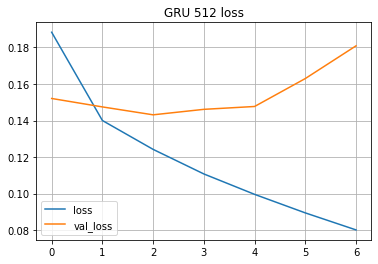

In [ ]:
hist4[['loss', 'val_loss']].plot()
plt.title('GRU 512 loss')
plt.grid()
plt.show()

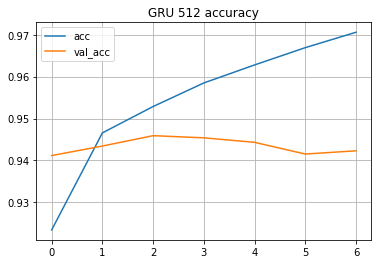

In [ ]:
hist4[['acc', 'val_acc']].plot()
plt.title('GRU 512 accuracy')
plt.grid()
plt.show()

In [ ]:
best_model4 = keras.models.load_model('best_model4.h5')
test_loss, test_acc = best_model4.evaluate(X_test, y_test, verbose=1)
pred = best_model4.predict(X_test)
print('model accuracy:', test_acc)

5469/5469 [==============================] - 55s 10ms/step - loss: 0.1443 - acc: 0.9444
model accuracy: 0.9444199800491333


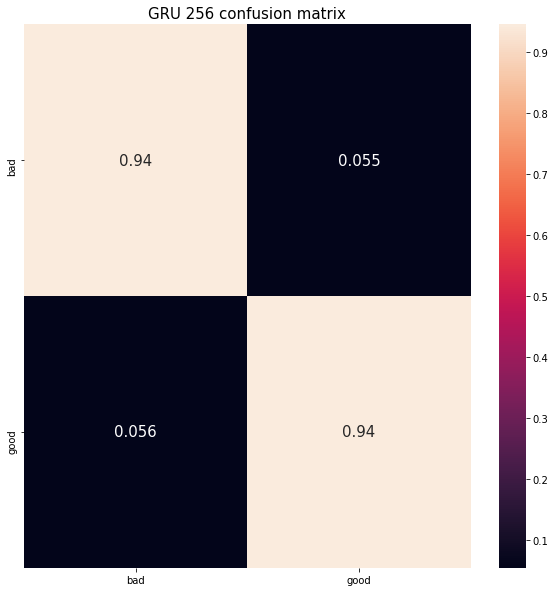

In [ ]:
a = y_test.to_numpy(int)
b = np.around(pred, 0).astype(int).reshape(-1,)
conf_matrix = pd.DataFrame(confusion_matrix(a, b), index = ['bad', 'good'], columns=['bad', 'good'])
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, annot=True, annot_kws={'size':15})     # annot=True: 각 셀에 숫자 입력
plt.title('GRU 256 confusion matrix', fontsize=15)
plt.show()

# 1D CNN

## rmsprop

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, 256))
model.add(Dropout(0.3))
model.add(Conv1D(256, 3, padding='valid', activation='relu'))
model.add(GlobalMaxPool1D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model5.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [ ]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics='acc')
history = model.fit(X_train, y_train, epochs=100, callbacks=[es, mc], validation_split=0.2)

Epoch 1/100
13125/13125 [==============================] - 275s 21ms/step - loss: 0.1916 - acc: 0.9258 - val_loss: 0.1537 - val_acc: 0.9425

Epoch 00001: val_acc improved from -inf to 0.94252, saving model to best_model5.h5
Epoch 2/100
13125/13125 [==============================] - 283s 22ms/step - loss: 0.1802 - acc: 0.9410 - val_loss: 0.1541 - val_acc: 0.9453

Epoch 00002: val_acc improved from 0.94252 to 0.94527, saving model to best_model5.h5
Epoch 3/100
13125/13125 [==============================] - 270s 21ms/step - loss: 0.1812 - acc: 0.9427 - val_loss: 0.1612 - val_acc: 0.9453

Epoch 00003: val_acc did not improve from 0.94527
Epoch 4/100
13125/13125 [==============================] - 281s 21ms/step - loss: 0.1910 - acc: 0.9418 - val_loss: 0.1704 - val_acc: 0.9437

Epoch 00004: val_acc did not improve from 0.94527
Epoch 5/100
13125/13125 [==============================] - 280s 21ms/step - loss: 0.1957 - acc: 0.9405 - val_loss: 0.2093 - val_acc: 0.9391

Epoch 00005: val_acc did n

In [ ]:
hist = pd.DataFrame(history.history)

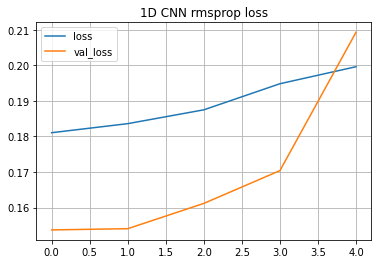

In [ ]:
hist[['loss', 'val_loss']].plot()
plt.title('1D CNN rmsprop loss')
plt.grid()
plt.show()

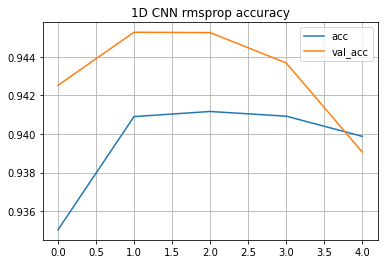

In [ ]:
hist[['acc', 'val_acc']].plot()
plt.title('1D CNN rmsprop accuracy')
plt.grid()
plt.show()

### confusion matrix

In [ ]:
best_model = keras.models.load_model('best_model5.h5')
test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=1)
pred = best_model.predict(X_test)
print('model accuracy:', test_acc)

5469/5469 [==============================] - 28s 5ms/step - loss: 0.1560 - acc: 0.9432
model accuracy: 0.9432427883148193


In [ ]:
a = y_test.to_numpy(int)
b = np.around(pred, 0).astype(int).reshape(-1,)

In [ ]:
# confusion matrix 만들기
conf_matrix = pd.DataFrame(confusion_matrix(a, b), index = ['bad', 'good'], columns=['bad', 'good'])

# normalize
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

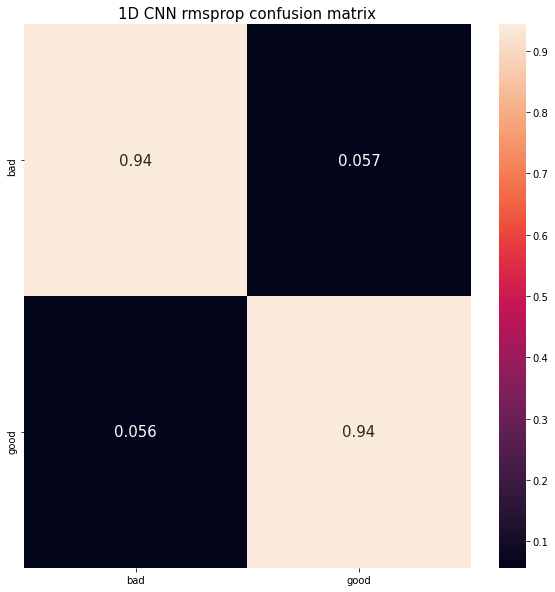

In [ ]:
# 시각화
plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, annot=True, annot_kws={'size':15})     # annot=True: 각 셀에 숫자 입력
plt.title('1D CNN rmsprop confusion matrix', fontsize=15)
plt.show()

### 실제 샘플 예측

In [ ]:
sentiment_predict("I purchased my first laminator and had no idea what thermal pouches to purchase. I was not sure what brand would be best and what thickness would be most effective, the 3mil or 5mil. After much thought I finally decided to give these a try and I'm really glad I did! I don't have anything to compare them to as this was my first time using these; however, they worked great and I didn't have any issues. These are the 3mil. When I run out I will be purchasing more!")

85.34034490585327% 확률로 긍정 리뷰입니다.


In [ ]:
sentiment_predict("Waste of time and money. I had been using Scotch brand which worked beautifully. Then I switched to these. Not one thing laminated was right. What I laminated was ruined, it was to late to be able to return the pouches because I ordered them at the same time as the Scotch ones which I used first. So waste of money and huge waste of my time trying to laminate things and then fix them.")

99.97278518567327% 확률로 부정 리뷰입니다.


## adam

In [ ]:
model2 = Sequential()
model2.add(Embedding(vocab_size, 256))
model2.add(Dropout(0.3))
model2.add(Conv1D(256, 3, padding='valid', activation='relu'))
model2.add(GlobalMaxPool1D())
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(1, activation='sigmoid'))

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model6.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [ ]:
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics='acc')
history2 = model2.fit(X_train, y_train, epochs=100, callbacks=[es, mc], validation_split=0.2)

Epoch 1/100
13125/13125 [==============================] - 568s 43ms/step - loss: 0.1830 - acc: 0.9273 - val_loss: 0.1454 - val_acc: 0.9434

Epoch 00001: val_acc improved from -inf to 0.94336, saving model to best_model6.h5
Epoch 2/100
13125/13125 [==============================] - 569s 43ms/step - loss: 0.1306 - acc: 0.9520 - val_loss: 0.1416 - val_acc: 0.9468

Epoch 00002: val_acc improved from 0.94336 to 0.94676, saving model to best_model6.h5
Epoch 3/100
 8166/13125 [=================>............] - ETA: 3:34 - loss: 0.1111 - acc: 0.9595

In [ ]:
hist2 = pd.DataFrame(history2.history)

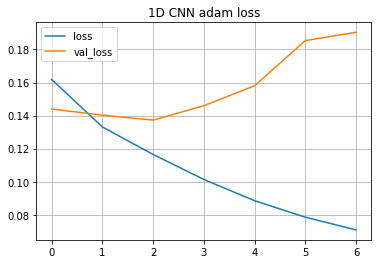

In [ ]:
hist2[['loss', 'val_loss']].plot()
plt.title('1D CNN adam loss')
plt.grid()
plt.show()

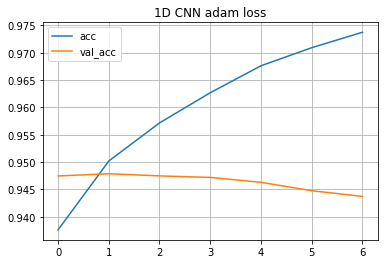

In [ ]:
hist2[['acc', 'val_acc']].plot()
plt.title('1D CNN adam loss')
plt.grid()
plt.show()

### confusion matrix

In [ ]:
best_model = keras.models.load_model('best_model6.h5')
test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=1)
pred = best_model.predict(X_test)
print('model accuracy:', test_acc)

5469/5469 [==============================] - 20s 4ms/step - loss: 0.1415 - acc: 0.9466
model accuracy: 0.9465915560722351


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
a = y_test.to_numpy(int)
b = np.around(pred, 0).astype(int).reshape(-1,)

In [ ]:
# confusion matrix 만들기
conf_matrix = pd.DataFrame(confusion_matrix(a, b), index = ['bad', 'good'], columns=['bad', 'good'])

# normalize
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

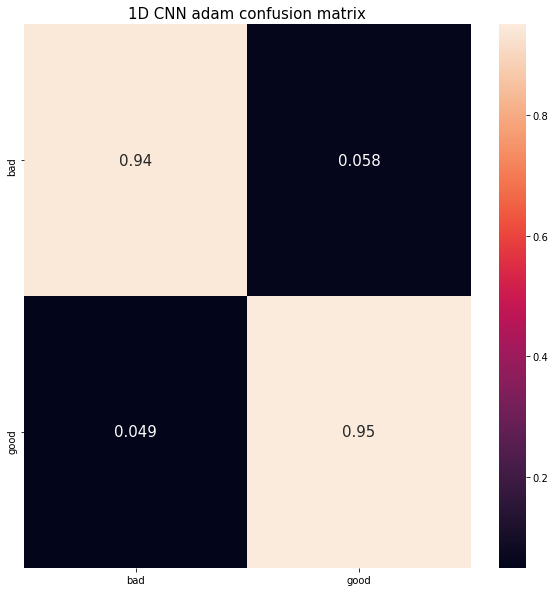

In [ ]:
# 시각화
plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, annot=True, annot_kws={'size':15})     # annot=True: 각 셀에 숫자 입력
plt.title('1D CNN adam confusion matrix', fontsize=15)
plt.show()

### 실제 샘플 예측

In [ ]:
sentiment_predict("I purchased my first laminator and had no idea what thermal pouches to purchase. I was not sure what brand would be best and what thickness would be most effective, the 3mil or 5mil. After much thought I finally decided to give these a try and I'm really glad I did! I don't have anything to compare them to as this was my first time using these; however, they worked great and I didn't have any issues. These are the 3mil. When I run out I will be purchasing more!")

94.98475193977356% 확률로 긍정 리뷰입니다.


In [ ]:
sentiment_predict("Waste of time and money. I had been using Scotch brand which worked beautifully. Then I switched to these. Not one thing laminated was right. What I laminated was ruined, it was to late to be able to return the pouches because I ordered them at the same time as the Scotch ones which I used first. So waste of money and huge waste of my time trying to laminate things and then fix them.")

99.74399220664054% 확률로 부정 리뷰입니다.
